In [79]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, MaxPooling1D, Input, Flatten
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

In [4]:
import DataProvider

### Build CNN model

In [80]:
def build_model(max_features_num, maxlen):
    """Build CNN model"""
    model = Sequential()
    model.add(Conv1D(64, 3, strides=1, 
                     input_shape=(maxlen,1),
                     padding='valid', 
                     data_format='channels_last', 
                     dilation_rate=1, 
                     activation='relu', 
                     use_bias=True, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='zeros', 
                     kernel_regularizer=None, 
                     bias_regularizer=None, 
                     activity_regularizer=None, 
                     kernel_constraint=None, 
                     bias_constraint=None))
    model.add(MaxPooling1D(pool_size=2, 
                           strides=None, 
                           padding='valid', 
                           data_format='channels_last'))
    model.add(Conv1D(32, 3, strides=1, 
                     padding='valid', 
                     data_format='channels_last', 
                     dilation_rate=1, 
                     activation='relu', 
                     use_bias=True, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='zeros', 
                     kernel_regularizer=None, 
                     bias_regularizer=None, 
                     activity_regularizer=None, 
                     kernel_constraint=None, 
                     bias_constraint=None))
    model.add(MaxPooling1D(pool_size=2, 
                           strides=None, 
                           padding='valid', 
                           data_format='channels_last'))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['binary_crossentropy','acc'])

    return model

### Load data

In [8]:
benigns, dgas = DataProvider.get_domains_data()
X = benigns + dgas

In [9]:
# Generate a dictionary of valid characters
unique_chars = enumerate(set(''.join(X))) 
chars_dict = dict()
for i, x in unique_chars: #index of enum starts with 0
    #print('i: ' + str(i) + '  x: ' + x)
    chars_dict[x] = i + 1 #leave 0 for padding

In [10]:
#index 0 is also going to be a feature(padding/unknown).
max_features_num = len(chars_dict) + 1

#max length will be the max length of domain in our dataset
maxlen = np.max([len(x) for x in X])

In [63]:
maxlen

73

In [11]:
# Convert characters to int
X_in_int = []
for domain in X:
    domain_in_int = []
    for c in domain:
        domain_in_int.append(chars_dict[c])
    X_in_int.append(domain_in_int)

In [12]:
X_in_int[1]

[13, 36, 25, 18, 25, 12, 9, 23, 35, 36, 7]

In [13]:
X[1]

'youtube.com'

In [14]:
#update X
X = X_in_int

In [15]:
#pad to max length
X = sequence.pad_sequences(X, maxlen=maxlen)

In [58]:
X.shape

(3016336, 73)

In [16]:
#Generate corresponding Y, 0 for 'benign'; 1 for 'dga'
Y = np.hstack([np.zeros(len(benigns)),np.ones(len(dgas))])

### Train the model
Beacuse of the huge size of data, we decided to resample to get a smaller set for training.

Because of the size of benigns domains is 1M, the cut point will be the index of the last benigns domain, which will be:

In [17]:
pos_neg_cutpoint = len(benigns)
print("The cut point will be "+ str(pos_neg_cutpoint))

The cut point will be 1000000


Now, randomly select the same amount of domains from both benigns and dgas.

In [19]:
import random

In [87]:
#set new sampling szie as 50K
sampling_size = 150000

pos_indices = random.sample(range(pos_neg_cutpoint),sampling_size)
neg_indices = random.sample(range(pos_neg_cutpoint, len(X)),sampling_size)

In [88]:
new_X = X[pos_indices + neg_indices]
new_Y = Y[pos_indices + neg_indices]

In [89]:
new_X.shape

(300000, 73)

In [91]:
newnew_x = np.reshape(new_X,(300000,73,1))

In [92]:
newnew_x.shape

(300000, 73, 1)

In [93]:
len(new_X)

300000

#### Fit the model

In [94]:
#training parameters

max_epoch=25
nfolds=10
batch_size=128

In [95]:
#call backs
from keras.callbacks import EarlyStopping
cb = []

cb.append(EarlyStopping(monitor='val_loss', 
                        min_delta=0, #an absolute change of less than min_delta, will count as no improvement
                        patience=2, #number of epochs with no improvement after which training will be stopped
                        verbose=0, 
                        mode='auto', 
                        baseline=None, 
                        restore_best_weights=False))

In [96]:
model = build_model(max_features_num, maxlen)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 71, 64)            256       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 35, 64)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 33, 32)            6176      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 16, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 513       
Total params: 6,945
Trainable params: 6,945
Non-trainable params: 0
_________________________________________________________________


In [97]:
history = model.fit(x=newnew_x, y=new_Y, 
                    batch_size=batch_size, 
                    epochs=max_epoch, 
                    verbose=1, 
                    callbacks=cb, 
                    validation_split=0.2, #
                    validation_data=None, 
                    shuffle=True, 
                    class_weight=None, 
                    sample_weight=None, 
                    initial_epoch=0,
                    steps_per_epoch=None, 
                    validation_steps=None)

Train on 240000 samples, validate on 60000 samples
Epoch 1/25
240000/240000 [==============================] - 38s 158us/step - loss: 0.4408 - binary_crossentropy: 0.4408 - acc: 0.7994 - val_loss: 0.7800 - val_binary_crossentropy: 0.7800 - val_acc: 0.6464
Epoch 2/25
240000/240000 [==============================] - 38s 157us/step - loss: 0.3821 - binary_crossentropy: 0.3821 - acc: 0.8348 - val_loss: 0.5306 - val_binary_crossentropy: 0.5306 - val_acc: 0.7395
Epoch 3/25
240000/240000 [==============================] - 38s 158us/step - loss: 0.3559 - binary_crossentropy: 0.3559 - acc: 0.8481 - val_loss: 0.4673 - val_binary_crossentropy: 0.4673 - val_acc: 0.7718
Epoch 4/25
240000/240000 [==============================] - 38s 159us/step - loss: 0.3375 - binary_crossentropy: 0.3375 - acc: 0.8570 - val_loss: 0.4152 - val_binary_crossentropy: 0.4152 - val_acc: 0.8043
Epoch 5/25
240000/240000 [==============================] - 38s 158us/step - loss: 0.3235 - binary_crossentropy: 0.3235 - acc: 0.

In [98]:
model.save('CNN_on_300K')

#### Plot training & validation accuracy values 

In [99]:
import matplotlib.pyplot as plt 

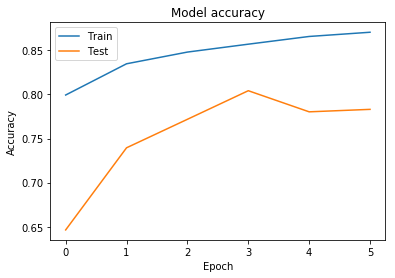

In [100]:
# Plot training & validation accuracy values 
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.title('Model accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show() 

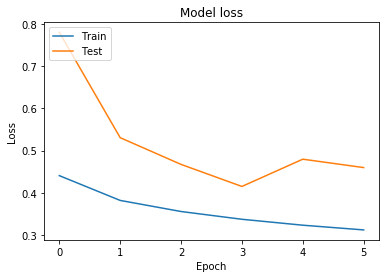

In [101]:

# Plot training & validation loss values 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

### Legacy code

In [ ]:
output_data = []

for fold in range(nfolds):
    print("fold %u/%u" % (fold+1, nfolds))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

    print('Build model...')
    model = build_model(max_features_num, maxlen)

    print("Train...")
    X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train, test_size=0.05)
    best_iter = -1
    best_auc = 0.0
    out_data = {}

    for ep in range(max_epoch):
        model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1)

        t_probs = model.predict_proba(X_holdout)
        t_auc = sklearn.metrics.roc_auc_score(y_holdout, t_probs)

        print('Epoch %d: auc = %f (best=%f)' % (ep, t_auc, best_auc))

        if t_auc > best_auc:
            best_auc = t_auc
            best_iter = ep

            probs = model.predict_proba(X_test)

            out_data = {'y':y_test, 'probs':probs, 'epochs': ep,
                        'confusion_matrix': sklearn.metrics.confusion_matrix(y_test, probs > .5)}

            print(sklearn.metrics.confusion_matrix(y_test, probs > .5))
        else:
            # No longer improving...break and calculate statistics
            if (ep-best_iter) > 2:
                break

    output_data.append(out_data)